In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from aging.behavior.syllables import relabel_by_usage
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import r2_score, accuracy_score
from toolz import frequencies, sliding_window
from aging.plotting import format_plots, PlotConfig, save_factory, figure
from sklearn.metrics import confusion_matrix

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "age-regression", tight_layout=False)

In [3]:
def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9


def zscore(df):
    return (df - df.mean()) / df.std()

In [4]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_03/ontogeny_males_syllable_df.parquet')
df, usage_map = relabel_by_usage(df)
df['age'] = df['age'].map(age_map)

In [5]:
scalar_quantiles = df.groupby(["age", "uuid"], sort=False)[
    # ["velocity_2d_mm", "height_ave_mm", "width_mm", "length_mm"]
    ["height_ave_mm", "width_mm", "length_mm"]
].quantile(np.linspace(0.1, 0.9, 11))
scalar_quantiles.index.rename("quantile", level=2, inplace=True)
tbl = zscore(scalar_quantiles.pivot_table(values=scalar_quantiles.columns, columns='quantile', index=['age', 'uuid'])).fillna(0)

In [6]:
tbl.head()

height_ave_mm                      \
quantile                                          0.10      0.18      0.26   
age uuid                                                                     
3.0 063d2dfb-e67f-46f9-b852-f86e7de2c000     -2.504888 -2.572985 -2.633594   
    251c80c7-7b97-4a35-83fd-2d0b8cf6a1c0     -1.629928 -1.650736 -1.654714   
    26c1b888-f160-4443-9035-de537caf900d     -2.477731 -2.517718 -2.541279   
    487e985c-d361-44ab-9e71-dd05ddf77d98     -2.249283 -2.235412 -2.222912   
    4e61feba-3954-41c7-960f-2f53a4e8ea99     -1.918712 -1.946931 -1.942867   

                                                                        \
quantile                                      0.34      0.42      0.50   
age uuid                                                                 
3.0 063d2dfb-e67f-46f9-b852-f86e7de2c000 -2.790994 -2.865637 -2.943842   
    251c80c7-7b97-4a35-83fd-2d0b8cf6a1c0 -1.717517 -1.724707 -1.752165   
    26c1b888-f160-4443-9035-de537caf900d -2.637753 -2.643096 -2.649605   
    487e985c-d361-44ab-9e71-dd05ddf77d98 -2.304777 -2.326890 -2.379967   
    4e61feba-3954-41c7-960f-2f53a4e8ea99 -1.986000 -1.908805 -1.783548   

                                                                        \
quantile                                      0.58      0.66      0.74   
age uuid                                                                 
3.0 063d2dfb-e67f-46f9-b852-f86e7de2c000 -3.021978 -3.041994 -2.945668   
    251c80c7-7b97-4a35-83fd-2d0b8cf6a1c0 -1.825429 -1.913087 -1.938790   
    26c1b888-f160-4443-9035-de537caf900d -2.660705 -2.656368 -2.599480   
    487e985c-d361-44ab-9e71-dd05ddf77d98 -2.448378 -2.472186 -2.415072   
    4e61feba-3954-41c7-960f-2f53a4e8ea99 -1.691848 -1.597381 -1.545256   

                                                    ...  width_mm            \
quantile                                      0.82  ...      0.18      0.26   
age uuid                                            ...                       
3.0 063d2dfb-e67f-46f9-b852-f86e7de2c000 -2.799996  ... -1.813043 -1.814542   
    251c80c7-7b97-4a35-83fd-2d0b8cf6a1c0 -1.907148  ... -1.462029 -1.463384   
    26c1b888-f160-4443-9035-de537caf900d -2.535634  ... -1.653567 -1.659319   
    487e985c-d361-44ab-9e71-dd05ddf77d98 -2.346764  ... -1.665376 -1.670115   
    4e61feba-3954-41c7-960f-2f53a4e8ea99 -1.581703  ... -1.584833 -1.588513   

                                                                        \
quantile                                      0.34      0.42      0.50   
age uuid                                                                 
3.0 063d2dfb-e67f-46f9-b852-f86e7de2c000 -1.817358 -1.819735 -1.825693   
    251c80c7-7b97-4a35-83fd-2d0b8cf6a1c0 -1.470004 -1.475641 -1.483952   
    26c1b888-f160-4443-9035-de537caf900d -1.671638 -1.681331 -1.694430   
    487e985c-d361-44ab-9e71-dd05ddf77d98 -1.682152 -1.692979 -1.706241   
    4e61feba-3954-41c7-960f-2f53a4e8ea99 -1.596875 -1.605982 -1.614419   

                                                                        \
quantile                                      0.58      0.66      0.74   
age uuid                                                                 
3.0 063d2dfb-e67f-46f9-b852-f86e7de2c000 -1.833087 -1.843749 -1.729122   
    251c80c7-7b97-4a35-83fd-2d0b8cf6a1c0 -1.495421 -1.502529 -1.414525   
    26c1b888-f160-4443-9035-de537caf900d -1.709661 -1.726494 -1.630724   
    487e985c-d361-44ab-9e71-dd05ddf77d98 -1.722765 -1.736900 -1.636116   
    4e61feba-3954-41c7-960f-2f53a4e8ea99 -1.627641 -1.639833 -1.546085   

                                                              
quantile                                      0.82      0.90  
age uuid                                                      
3.0 063d2dfb-e67f-46f9-b852-f86e7de2c000 -1.606647 -1.521459  
    251c80c7-7b97-4a35-83fd-2d0b8cf6a1c0 -1.317277 -1.244387  
    26c1b888-f160-4443-9035-de537caf900d -1.529113 -1.464782  
    487e985c-d361-44ab-9e71-dd05d

In [7]:
pipeline = make_pipeline(
    PCA(n_components=10),
    StandardScaler(),
    LogisticRegression(C=0.5, max_iter=500)
)
y = tbl.index.get_level_values(0).astype(int)

grid = GridSearchCV(
    pipeline,
    dict(pca__n_components=range(1, 20), logisticregression__C=np.logspace(-1, 4, 20)),
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

grid.fit(tbl, y)
# grid.best_params_, grid.best_score_

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('pca', PCA(n_components=10)),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=0.5,
                                                           max_iter=500))]),
             n_jobs=2,
             param_grid={'logisticregression__C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04]),
                         'pca__n_components': range(1, 20)},
             scoring='accuracy')

In [8]:
unique = np.unique(y)
unique

array([ 3,  5,  7,  9, 12, 24, 48, 72, 88])

In [9]:
preds = cross_val_predict(
    pipeline.set_params(**grid.best_params_),
    tbl,
    y,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

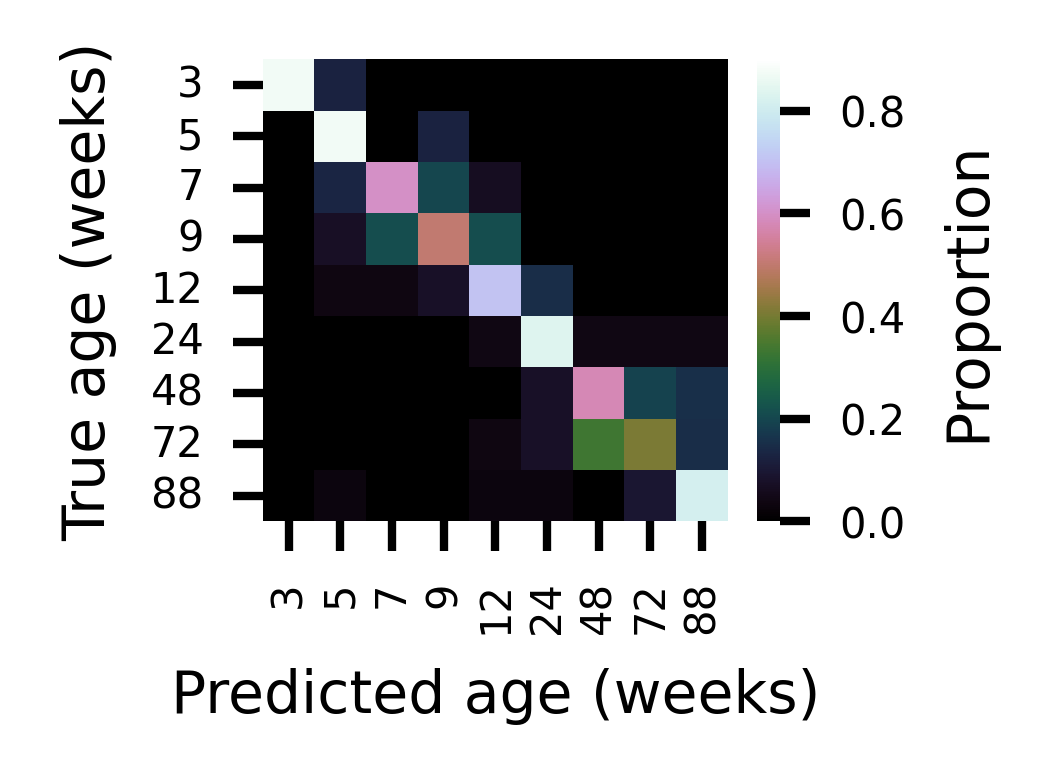

In [10]:
cm = confusion_matrix(y, preds, labels=unique)
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=unique, index=unique)

fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.9,
    vmin=0,
)
ax.set(xlabel="Predicted age (weeks)", ylabel="True age (weeks)")
saver(fig, "scalar-classifier-cm");

In [11]:
acc = accuracy_score(y, preds)
acc

0.6852791878172588

In [12]:
n_shuffs = 300
y_shuff = y.to_numpy().copy()
shuff_acc = []
for i in range(n_shuffs):
    np.random.shuffle(y_shuff)
    preds = cross_val_predict(
        pipeline.set_params(**grid.best_params_),
        tbl,
        y_shuff,
        cv=StratifiedKFold(n_splits=5),
        n_jobs=2,
    )
    shuff_acc.append(accuracy_score(y_shuff, preds))

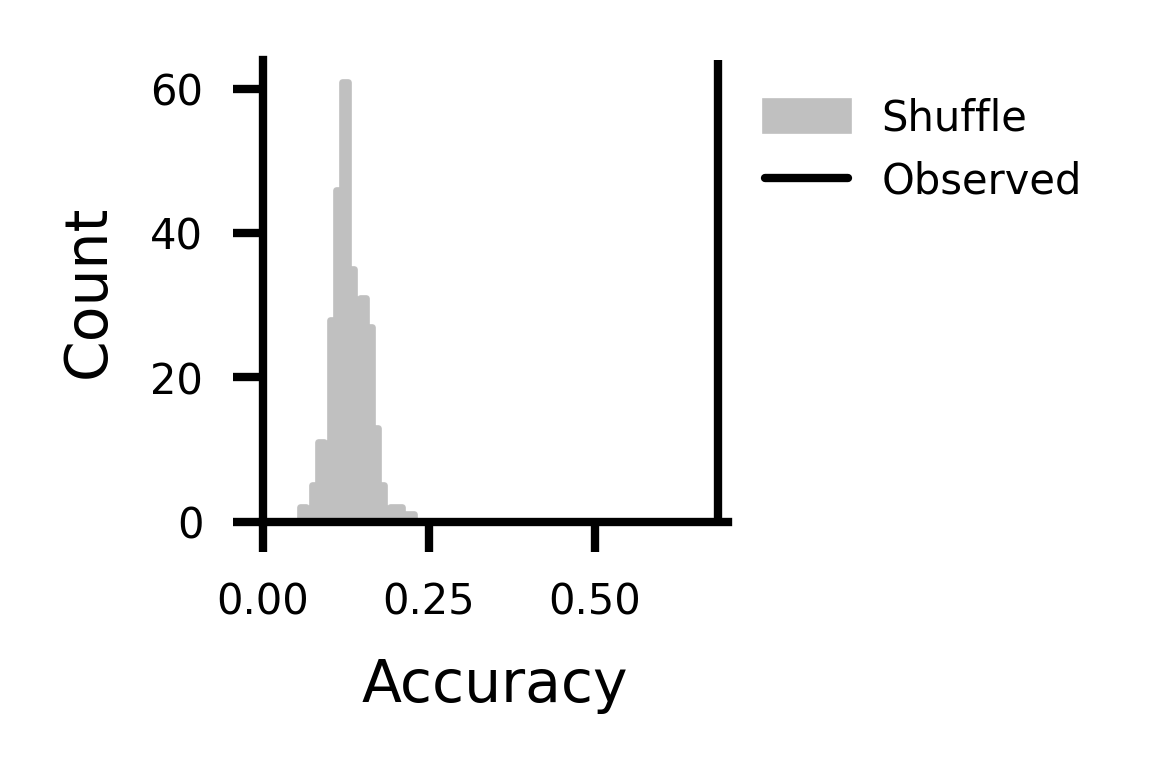

In [13]:
fig = figure(1, 1)
ax = sns.histplot(
    shuff_acc,
    label="Shuffle",
    color="silver",
    alpha=1,
    fill=True,
    element="step",
    line_kws=dict(lw=0),
)
ax.axvline(acc, label="Observed", color="k")
ax.set(xlabel="Accuracy", xlim=(0, 0.7))
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc="upper left")
sns.despine()
saver(fig, "scalar-classifier-acc-vs-shuff");

In [14]:
pipeline = make_pipeline(
    PCA(n_components=10),
    StandardScaler(),
    LogisticRegression(C=0.5)
)

y = tbl.index.get_level_values(0).astype(int)
scores = cross_val_score(pipeline, tbl, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')


In [15]:
np.mean(scores)

0.6192307692307691

In [16]:
scalar_quantiles = df.groupby(["age", "uuid"], sort=False)[
    # ["velocity_2d_mm", "recon_height", "recon_width", "recon_length"]
    ["recon_height", "recon_width", "recon_length"]
].quantile(np.linspace(0.1, 0.9, 9))
scalar_quantiles.index.rename("quantile", level=2, inplace=True)
tbl = zscore(scalar_quantiles.pivot_table(values=scalar_quantiles.columns, columns='quantile', index=['age', 'uuid'])).fillna(0)

In [17]:
pipeline = make_pipeline(
    PCA(n_components=10),
    StandardScaler(),
    LogisticRegression(C=0.5, max_iter=500)
)
y = tbl.index.get_level_values(0).astype(int)

grid = GridSearchCV(
    pipeline,
    dict(pca__n_components=range(1, 20), logisticregression__C=np.logspace(-1, 4, 20)),
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

grid.fit(tbl, y)
grid.best_params_, grid.best_score_

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

({'logisticregression__C': 1.1288378916846888, 'pca__n_components': 14},
 0.5839743589743589)

In [18]:
unique = np.unique(unique)

In [19]:
preds = cross_val_predict(
    pipeline.set_params(**grid.best_params_),
    tbl,
    y,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

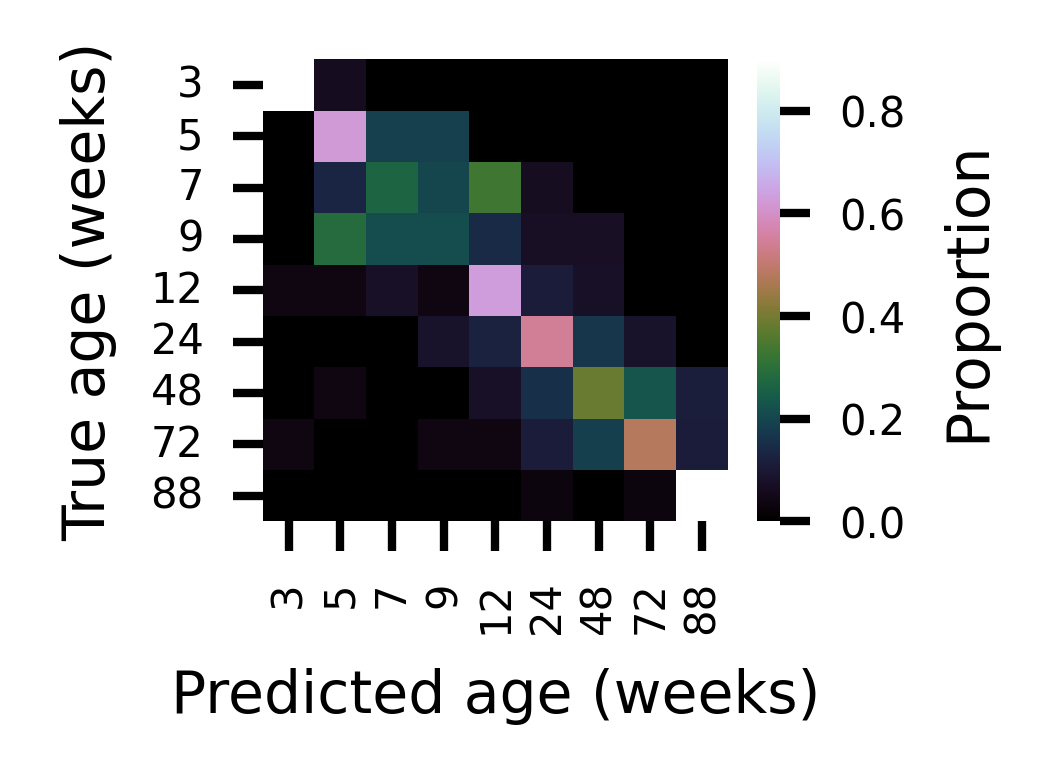

In [20]:
cm = confusion_matrix(y, preds, labels=unique)
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=unique, index=unique)

fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.9,
    vmin=0,
)
ax.set(xlabel="Predicted age (weeks)", ylabel="True age (weeks)")
saver(fig, "transformed-scalar-classifier-cm");

In [21]:
acc = accuracy_score(y, preds)

In [22]:
n_shuffs = 300
y_shuff = y.to_numpy().copy()
shuff_acc = []
for i in range(n_shuffs):
    np.random.shuffle(y_shuff)
    preds = cross_val_predict(
        pipeline.set_params(**grid.best_params_),
        tbl,
        y_shuff,
        cv=StratifiedKFold(n_splits=5),
        n_jobs=2,
    )
    shuff_acc.append(accuracy_score(y_shuff, preds))

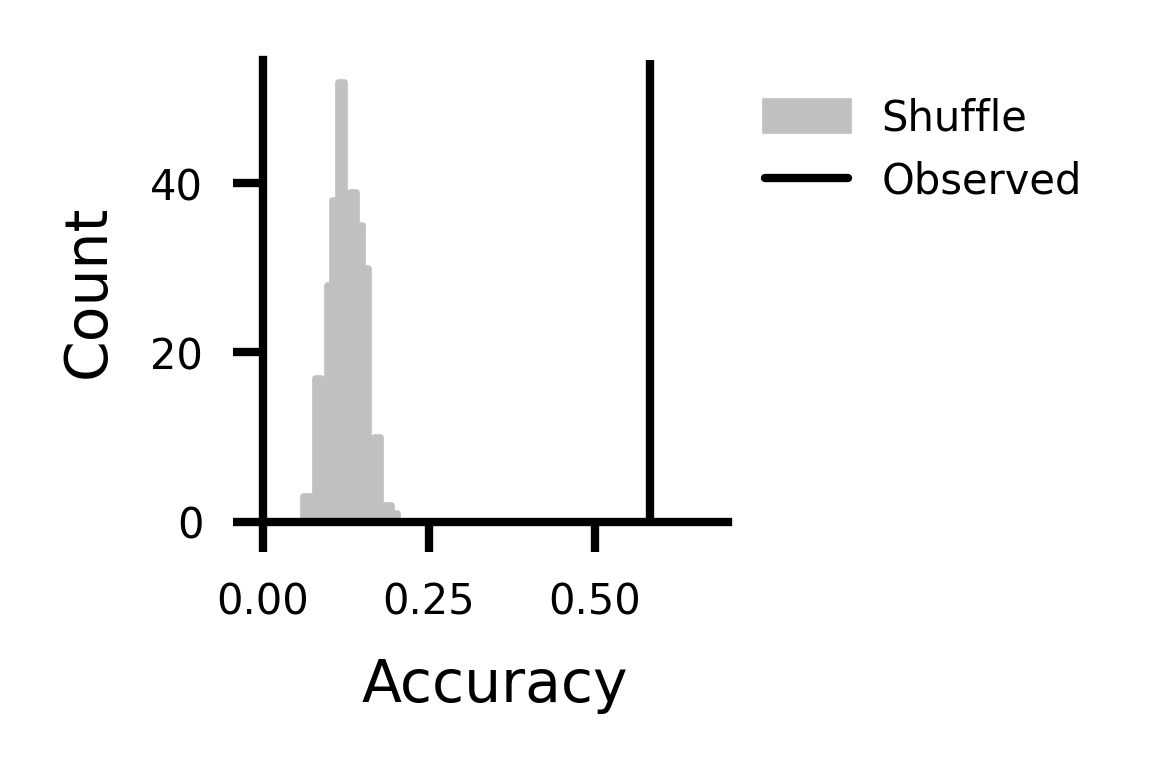

In [23]:
fig = figure(1, 1)
ax = sns.histplot(
    shuff_acc,
    label="Shuffle",
    color="silver",
    alpha=1,
    fill=True,
    element="step",
    line_kws=dict(lw=0),
)
ax.axvline(acc, label="Observed", color="k")
ax.set(xlabel="Accuracy", xlim=(0, 0.7))
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc="upper left")
sns.despine()
saver(fig, "transformed-scalar-classifier-acc-vs-shuff");

In [24]:
# e = grid.best_estimator_
# plt.imshow(e.steps[0][1].components_)
# plt.imshow(e.steps[-1][1].coef_)

## Just use medians

In [25]:
tbl = zscore(df.groupby(["age", "uuid"], sort=False)[
    # ["velocity_2d_mm", "height_ave_mm", "width_mm", "length_mm"]
    ["height_ave_mm", "width_mm", "length_mm"]
].median())

In [26]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.5, max_iter=500)
)
y = tbl.index.get_level_values(0).astype(int)

grid = GridSearchCV(
    pipeline,
    dict(logisticregression__C=np.logspace(-1, 4, 20)),
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

grid.fit(tbl, y)
# grid.best_params_, grid.best_score_

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=0.5,
                                                           max_iter=500))]),
             n_jobs=2,
             param_grid={'logisticregression__C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04])},
             scoring='accuracy')

In [27]:
grid.best_params_, grid.best_score_

({'logisticregression__C': 42.81332398719391}, 0.5933333333333334)

In [28]:
preds = cross_val_predict(
    pipeline.set_params(**grid.best_params_),
    tbl,
    y,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

In [29]:
unique = np.unique(y)
unique

array([ 3,  5,  7,  9, 12, 24, 48, 72, 88])

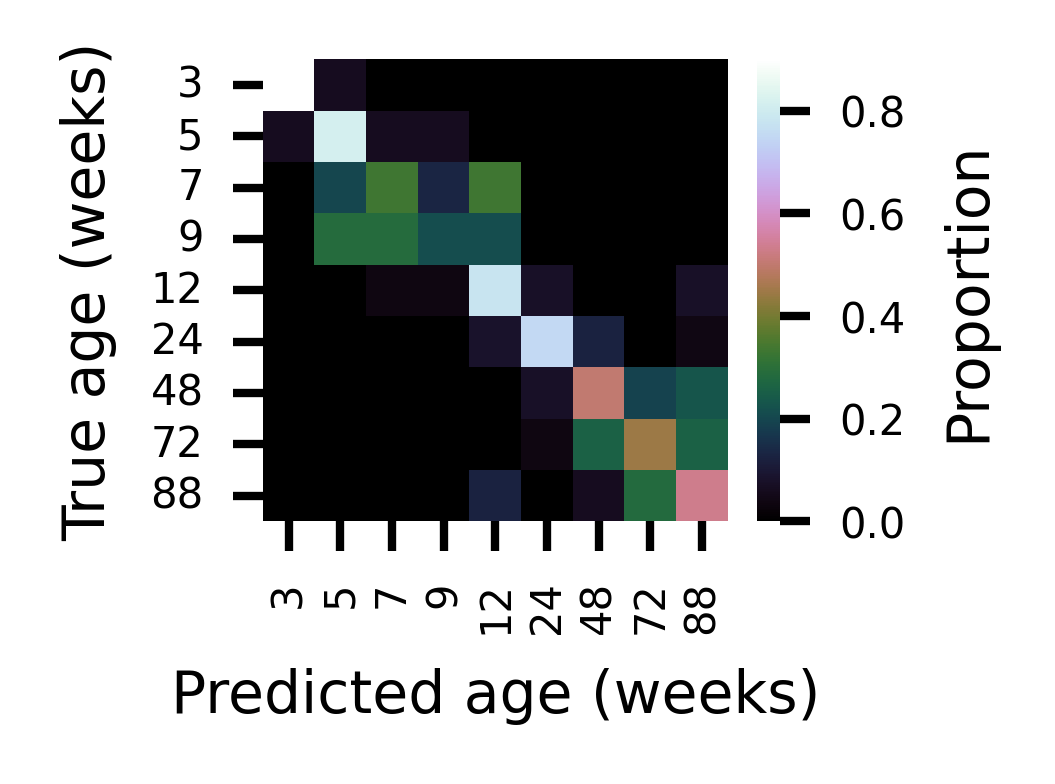

In [30]:
cm = confusion_matrix(y, preds, labels=unique)
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=unique, index=unique)

fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.9,
    vmin=0,
)
ax.set(xlabel="Predicted age (weeks)", ylabel="True age (weeks)")
saver(fig, "scalar-mean-classifier-cm");

In [31]:
acc = accuracy_score(y, preds)
acc

0.5939086294416244

In [32]:
n_shuffs = 300
y_shuff = y.to_numpy().copy()
shuff_acc = []
for i in range(n_shuffs):
    np.random.shuffle(y_shuff)
    preds = cross_val_predict(
        pipeline.set_params(**grid.best_params_),
        tbl,
        y_shuff,
        cv=StratifiedKFold(n_splits=5),
        n_jobs=2,
    )
    shuff_acc.append(accuracy_score(y_shuff, preds))

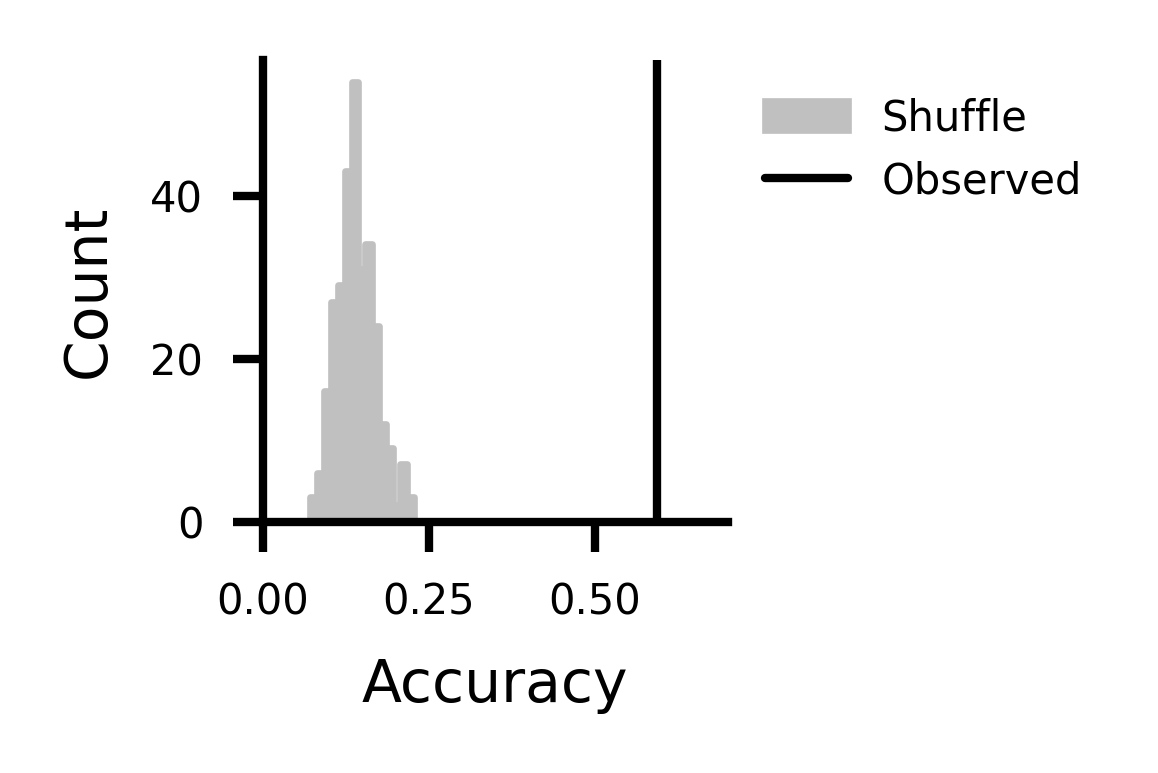

In [33]:
fig = figure(1, 1)
ax = sns.histplot(
    shuff_acc,
    label="Shuffle",
    color="silver",
    alpha=1,
    fill=True,
    element="step",
    line_kws=dict(lw=0),
)
ax.axvline(acc, label="Observed", color="k")
ax.set(xlabel="Accuracy", xlim=(0, 0.7))
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc="upper left")
sns.despine()
saver(fig, "scalar-mean-classifier-acc-vs-shuff");

In [34]:
tbl = zscore(df.groupby(["age", "uuid"], sort=False)[
    # ["velocity_2d_mm", "height_ave_mm", "width_mm", "length_mm"]
    ["recon_height", "recon_width", "recon_length"]
].median())

In [35]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.5, max_iter=500)
)
y = tbl.index.get_level_values(0).astype(int)

grid = GridSearchCV(
    pipeline,
    dict(logisticregression__C=np.logspace(-1, 4, 20)),
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

grid.fit(tbl, y)
# grid.best_params_, grid.best_score_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=0.5,
                                                           max_iter=500))]),
             n_jobs=2,
             param_grid={'logisticregression__C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04])},
             scoring='accuracy')

In [36]:
grid.best_params_, grid.best_score_

({'logisticregression__C': 143.8449888287663}, 0.44153846153846155)

In [37]:
preds = cross_val_predict(
    pipeline.set_params(**grid.best_params_),
    tbl,
    y,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

In [38]:
unique = np.unique(y)
unique

array([ 3,  5,  7,  9, 12, 24, 48, 72, 88])

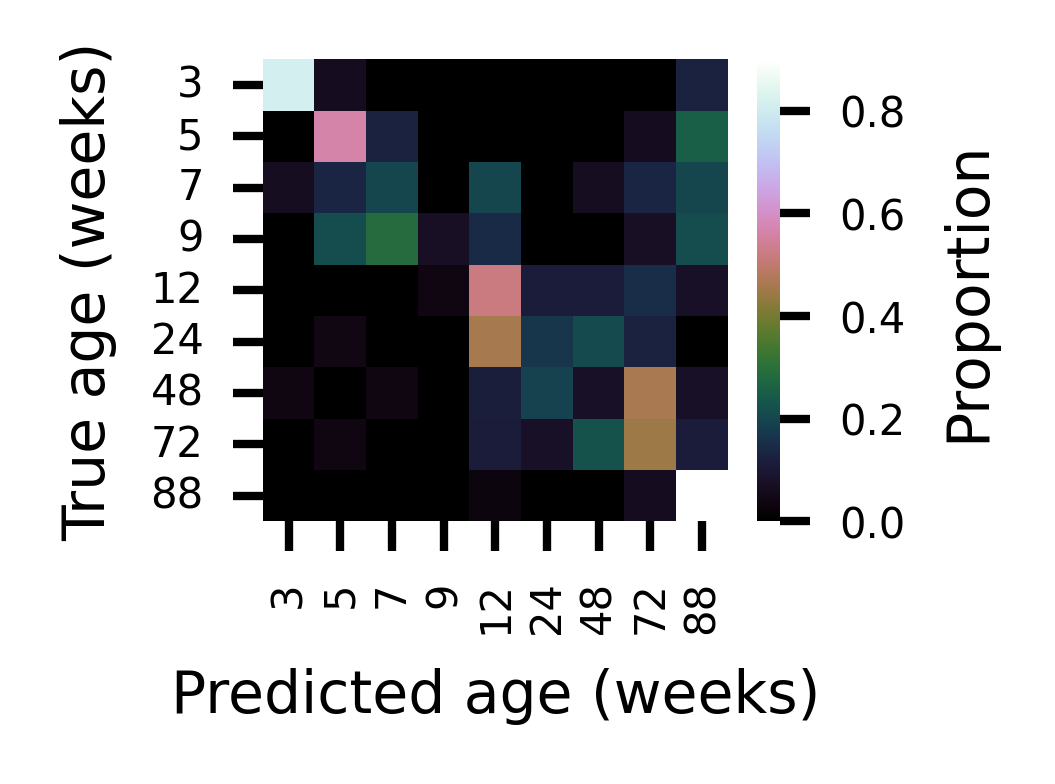

In [39]:
cm = confusion_matrix(y, preds, labels=unique)
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=unique, index=unique)

fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.9,
    vmin=0,
)
ax.set(xlabel="Predicted age (weeks)", ylabel="True age (weeks)")
saver(fig, "transformed-scalar-mean-classifier-cm");

In [40]:
acc = accuracy_score(y, preds)
acc

0.4416243654822335

In [41]:
n_shuffs = 300
y_shuff = y.to_numpy().copy()
shuff_acc = []
for i in range(n_shuffs):
    np.random.shuffle(y_shuff)
    preds = cross_val_predict(
        pipeline.set_params(**grid.best_params_),
        tbl,
        y_shuff,
        cv=StratifiedKFold(n_splits=5),
        n_jobs=2,
    )
    shuff_acc.append(accuracy_score(y_shuff, preds))

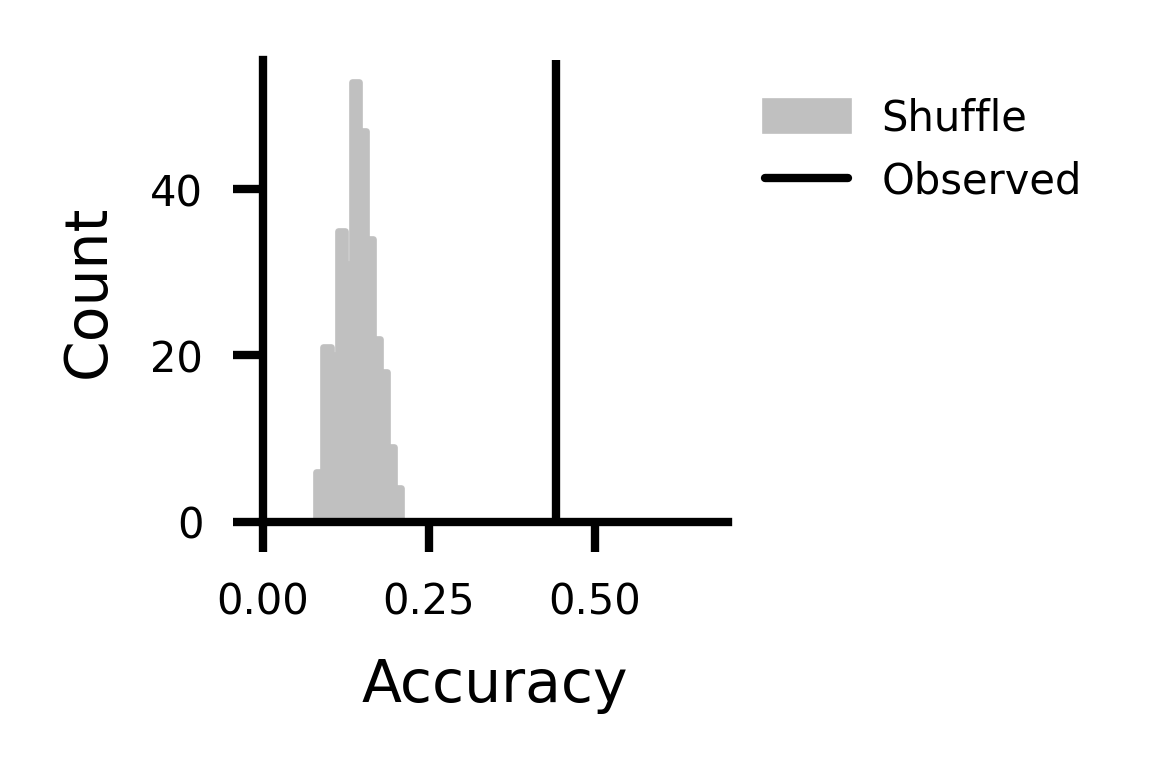

In [42]:
fig = figure(1, 1)
ax = sns.histplot(
    shuff_acc,
    label="Shuffle",
    color="silver",
    alpha=1,
    fill=True,
    element="step",
    line_kws=dict(lw=0),
)
ax.axvline(acc, label="Observed", color="k")
ax.set(xlabel="Accuracy", xlim=(0, 0.7))
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc="upper left")
sns.despine()
saver(fig, "transformed-scalar-mean-classifier-acc-vs-shuff");

## minmax

In [43]:
tbl = zscore(df.groupby(["age", "uuid"], sort=False)[
    # ["velocity_2d_mm", "height_ave_mm", "width_mm", "length_mm"]
    ["recon_height", "recon_width", "recon_length"]
].agg(['min', 'max']))

In [44]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.5, max_iter=500)
)
y = tbl.index.get_level_values(0).astype(int)

grid = GridSearchCV(
    pipeline,
    dict(logisticregression__C=np.logspace(-1, 4, 20)),
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

grid.fit(tbl, y)
# grid.best_params_, grid.best_score_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=0.5,
                                                           max_iter=500))]),
             n_jobs=2,
             param_grid={'logisticregression__C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04])},
             scoring='accuracy')

In [45]:
grid.best_params_, grid.best_score_

({'logisticregression__C': 42.81332398719391}, 0.34974358974358977)

In [46]:
preds = cross_val_predict(
    pipeline.set_params(**grid.best_params_),
    tbl,
    y,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

In [47]:
unique = np.unique(y)
unique

array([ 3,  5,  7,  9, 12, 24, 48, 72, 88])

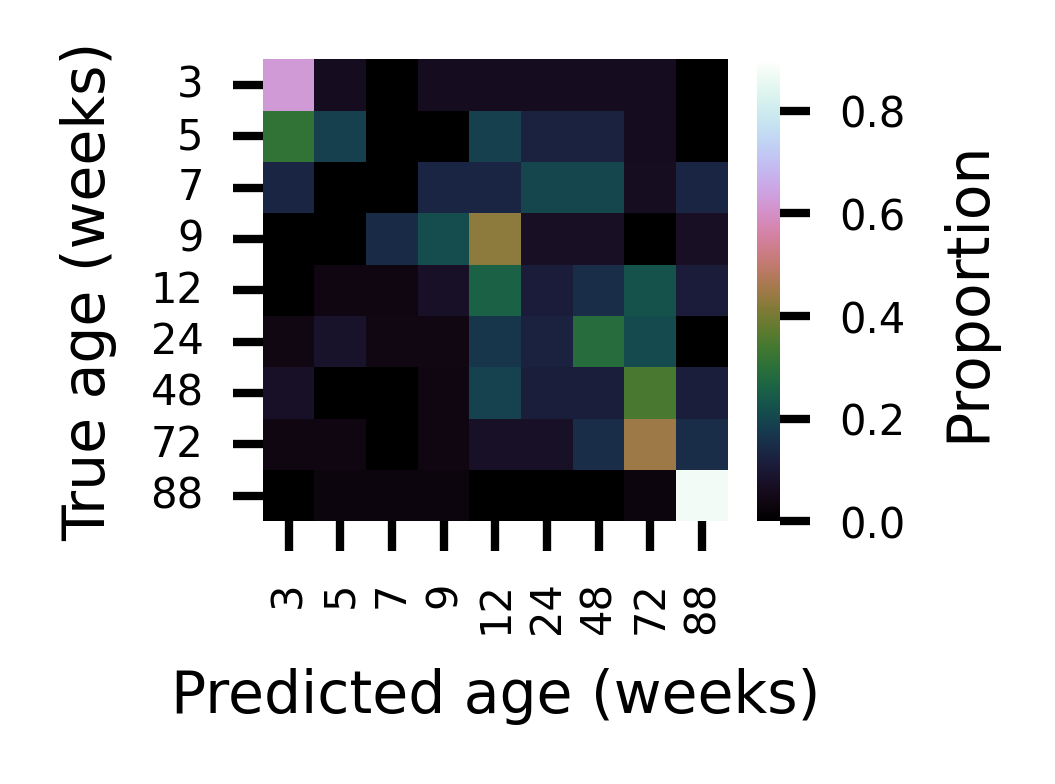

In [48]:
cm = confusion_matrix(y, preds, labels=unique)
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=unique, index=unique)

fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.9,
    vmin=0,
)
ax.set(xlabel="Predicted age (weeks)", ylabel="True age (weeks)")
saver(fig, "transformed-scalar-range-classifier-cm");

In [49]:
acc = accuracy_score(y, preds)
acc

0.350253807106599

In [50]:
n_shuffs = 300
y_shuff = y.to_numpy().copy()
shuff_acc = []
for i in range(n_shuffs):
    np.random.shuffle(y_shuff)
    preds = cross_val_predict(
        pipeline.set_params(**grid.best_params_),
        tbl,
        y_shuff,
        cv=StratifiedKFold(n_splits=5),
        n_jobs=2,
    )
    shuff_acc.append(accuracy_score(y_shuff, preds))

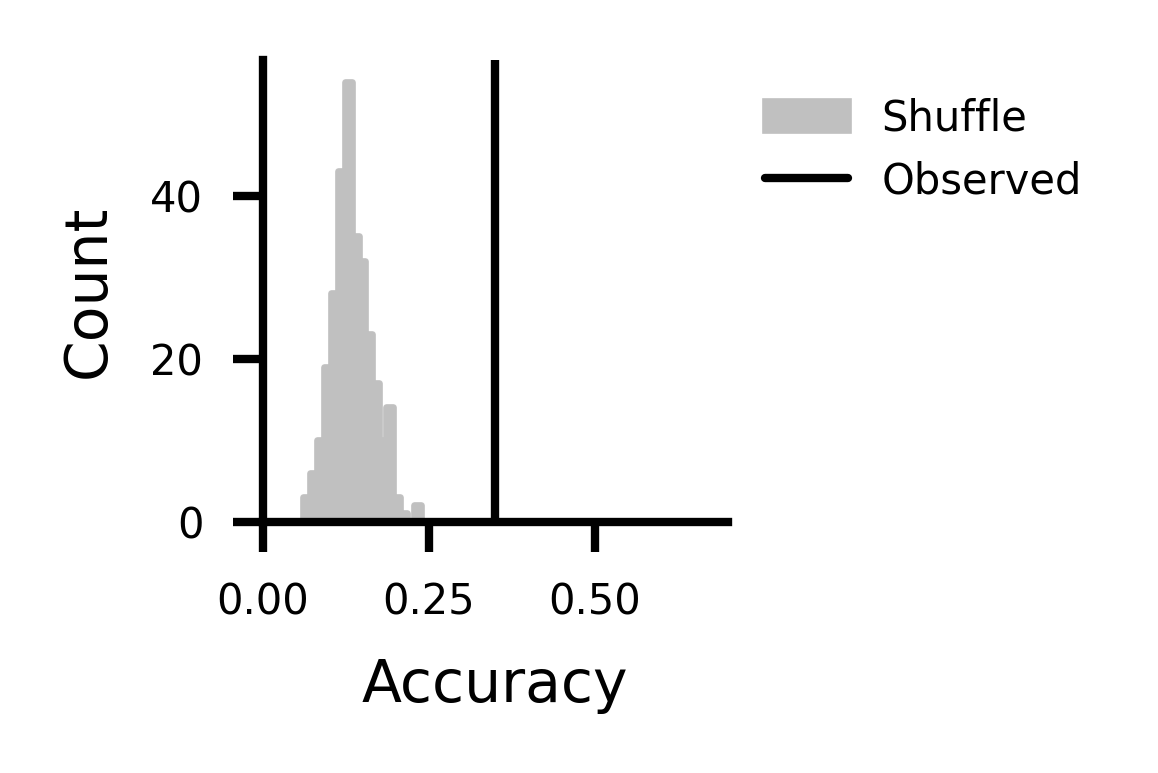

In [51]:
fig = figure(1, 1)
ax = sns.histplot(
    shuff_acc,
    label="Shuffle",
    color="silver",
    alpha=1,
    fill=True,
    element="step",
    line_kws=dict(lw=0),
)
ax.axvline(acc, label="Observed", color="k")
ax.set(xlabel="Accuracy", xlim=(0, 0.7))
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc="upper left")
sns.despine()
saver(fig, "transformed-scalar-range-classifier-acc-vs-shuff");

In [5]:
tbl = zscore(df.dropna(subset=["velocity_2d_mm", "height_ave_mm", "width_mm", "length_mm"]).groupby(["age", "uuid"], sort=False)[
    ["velocity_2d_mm", "height_ave_mm", "width_mm", "length_mm", "area_mm"]
    # ["height_ave_mm", "width_mm", "length_mm"]
].agg(['min', 'max'])).fillna(0)

In [6]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.5, max_iter=500)
)
y = tbl.index.get_level_values(0).astype(int)

grid = GridSearchCV(
    pipeline,
    dict(logisticregression__C=np.logspace(-1, 4, 20)),
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

grid.fit(tbl, y)
# grid.best_params_, grid.best_score_

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=0.5,
                                                           max_iter=500))]),
             n_jobs=2,
             param_grid={'logisticregression__C': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04])},
             scoring='accuracy')

In [7]:
grid.best_params_, grid.best_score_

({'logisticregression__C': 263.6650898730358}, 0.35025641025641024)

In [8]:
preds = cross_val_predict(
    pipeline.set_params(**grid.best_params_),
    tbl,
    y,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=2,
)

In [9]:
unique = np.unique(y)
unique

array([ 3,  5,  7,  9, 12, 24, 48, 72, 88])

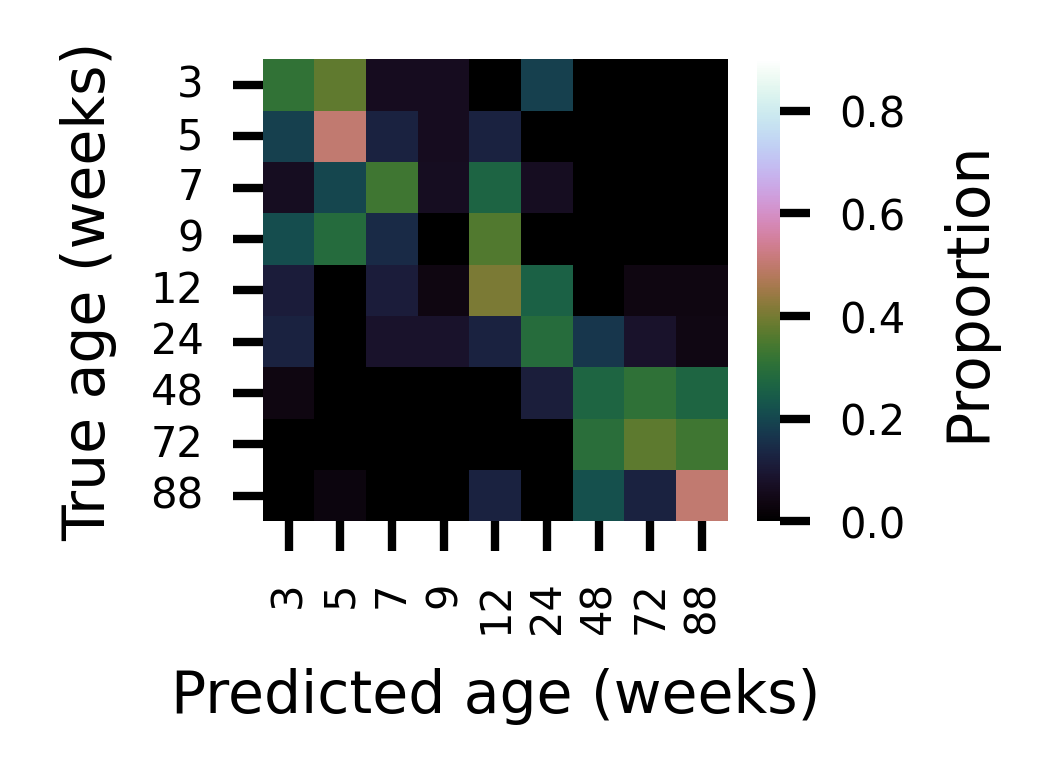

In [10]:
cm = confusion_matrix(y, preds, labels=unique)
cm_df = pd.DataFrame(cm / cm.sum(1, keepdims=True), columns=unique, index=unique)

fig = figure(1.25, 1)
ax = sns.heatmap(
    cm_df,
    annot=False,
    cmap="cubehelix",
    cbar_kws=dict(label="Proportion"),
    vmax=0.9,
    vmin=0,
)
ax.set(xlabel="Predicted age (weeks)", ylabel="True age (weeks)")
saver(fig, "scalar-range-classifier-cm");

In [11]:
acc = accuracy_score(y, preds)
acc

0.350253807106599

In [12]:
n_shuffs = 300
y_shuff = y.to_numpy().copy()
shuff_acc = []
for i in range(n_shuffs):
    np.random.shuffle(y_shuff)
    preds = cross_val_predict(
        pipeline.set_params(**grid.best_params_),
        tbl,
        y_shuff,
        cv=StratifiedKFold(n_splits=5),
        n_jobs=2,
    )
    shuff_acc.append(accuracy_score(y_shuff, preds))

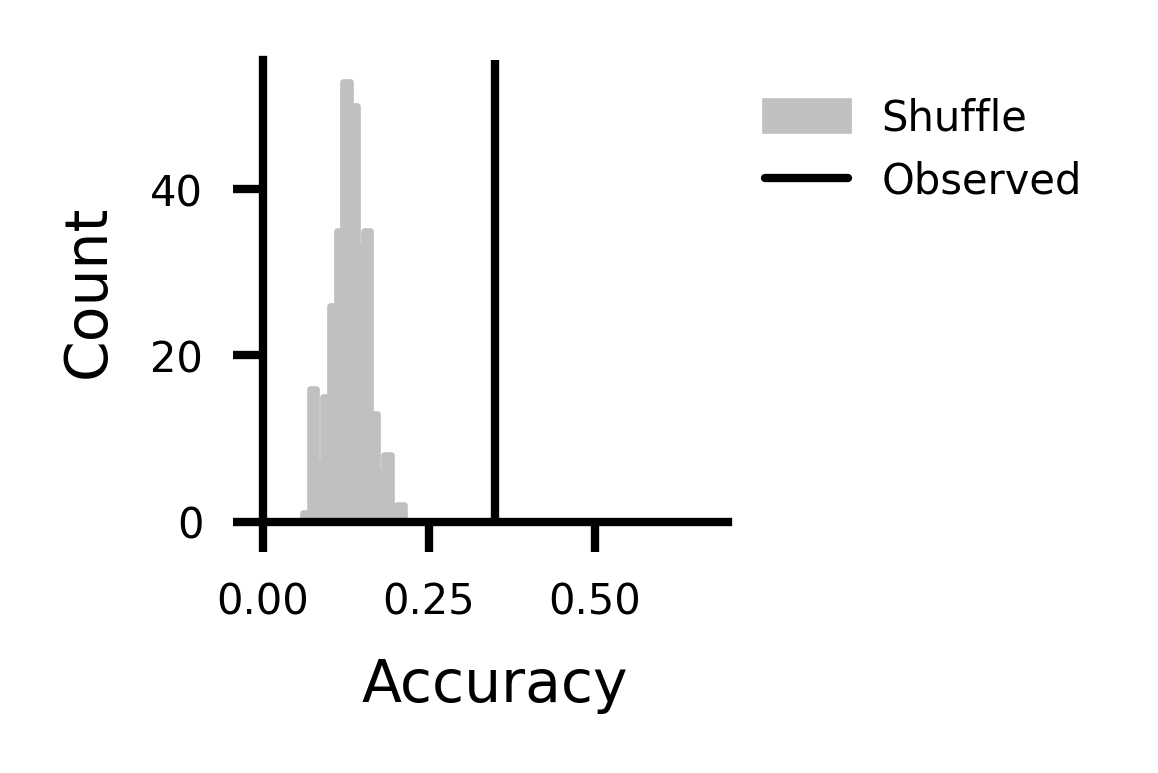

In [13]:
fig = figure(1, 1)
ax = sns.histplot(
    shuff_acc,
    label="Shuffle",
    color="silver",
    alpha=1,
    fill=True,
    element="step",
    line_kws=dict(lw=0),
)
ax.axvline(acc, label="Observed", color="k")
ax.set(xlabel="Accuracy", xlim=(0, 0.7))
ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc="upper left")
sns.despine()
saver(fig, "scalar-range-classifier-acc-vs-shuff");